In [ ]:
#卷积层的前向传播过程

#通过tf.get_variable的方法创建卷积核的权重变量和偏置项变量。卷积层的参数数量只和卷积核尺寸、深度以及当前层结点矩阵的深度有关。
#这里声明的参数变量是一个四维矩阵，前两个维度代表卷积核的尺寸，第三个维度代表当前层的深度，第四个代表卷积核的深度（卷积核数量）。
filter_weight=tf.get_variable('weights', [5, 5, 3, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))

#和卷积层的权重类似，当前层矩阵上不同位置的偏置项也是共享的，共有下一层深度个不同的偏置项。
#本案例16为卷积核的深度，即下一层结点矩阵的深度。
biases=tf.get_variable('biases', [16], initializer=tf._constant_initializer(0.1))

#tf.nn.conv2d提供了非常方便的函数来实现卷积层的前向传播算法。这个函数的第一个输入为当前层的结点张量。
#该张量是一个四维张量，后面三个维度对应一个结点张量，第一个维度对应输入批量。
#例如input[0,:,:,:]表示第一张图片。tf.nn.conv2d第二个参数提供了卷积层的权重，第三个参数为不同维度上的步幅。
#虽然第三个参数提供的是一个长度为4的数组，但第一维度和第四维度都必须为1，即一次一张图片一个色彩通道，卷积步幅只对长宽有效。
#最后一个参数是填充方法，TF中提供SAME和VALID，SAME表示添加0填充，VALID表示不添加。
conv=tf.nn.conv2d(input, filter_weights, strides=[1,1,1,1], padding='SAME')

#tf.nn.bias_add提供了方便的函数为每个结点加上偏置项。注意这里不能直接使用加法，因为矩阵上不同位置上的结点都需要加上相同的偏置项。
#若下一层大小为2×2，但偏置项只有一个数（深度为1），而2×2矩阵中每一个值都需要加上该偏置项。
bias=tf.nn.bias_add(conv, biases)

#将计算结果通过ReLU函数完成去线性化
actived_conv=tf.nn.relu(bias)


In [ ]:
#最大池化层的前向传播算法

#tf.nn.max_pool实现了最大池化层的前向传播过程，它的参数和tf.nn.conv2d函数类似。
#ksize提供了卷积核的尺寸，strides提供了步幅信息，padding提供是否使用0填充。
pool=tf.nn.max_pool(actived_conv, ksize=[1,3,3,1],strides=[1,2,2,1], padding='SAME')

### 卷积层与池化层理解
#### 1. 假设我们输入矩阵

$
M=\left(\begin{array}{c}
1&-1&0\\
-1&2&1\\
0&2&-2
\end{array}\right)
$

In [2]:
import tensorflow as tf
import numpy as np

M = np.array([
        [[1],[-1],[0]],
        [[-1],[2],[1]],
        [[0],[2],[-2]]
    ])

print ("Matrix shape is: ",M.shape)

Matrix shape is:  (3, 3, 1)


#### 2. 定义卷积核, 深度为1。
$
W=\left(\begin{array}{c}
1&-1\\
0&2
\end{array}\right)
$

In [3]:
filter_weight = tf.get_variable('weights', [2, 2, 1, 1], initializer = tf.constant_initializer([
                                                                        [1, -1],
                                                                        [0, 2]]))
biases = tf.get_variable('biases', [1], initializer = tf.constant_initializer(1))

In [4]:
#调整输入格式符合TensorFlow要求
M = np.asarray(M, dtype='float32')
M = M.reshape(1, 3, 3, 1)

In [6]:
#计算矩阵通过卷积核和池化滤波器计算后的结果
x = tf.placeholder('float32', [1, None, None, 1])
conv = tf.nn.conv2d(x, filter_weight, strides = [1, 2, 2, 1], padding = 'SAME')
bias = tf.nn.bias_add(conv, biases)
pool = tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    convoluted_M = sess.run(bias,feed_dict={x:M})
    pooled_M = sess.run(pool,feed_dict={x:M})
    
    print ("convoluted_M: \n", convoluted_M)
    print ("pooled_M: \n", pooled_M)

convoluted_M: 
 [[[[ 7.]
   [ 1.]]

  [[-1.]
   [-1.]]]]
pooled_M: 
 [[[[ 0.25]
   [ 0.5 ]]

  [[ 1.  ]
   [-2.  ]]]]


### LeNet-5 TensorFlow 实现

In [ ]:
#训练LeNet-5和前面全连接网络非常相似,
#调整输入数据占位符的搁置，输入为一个四维张量

#第一个维度表示一个batch中样本的数量，第二个维度和第三个维度表示图片尺寸，第四个维度是图片深度
x=tf.placeholder(tf.float32,[BATCH_SIZE,
                             mnist_inference.IMAGE_SIZE,
                             mnist_inference.IMAGE_SIZE,
                             mnist_inference.NUM_CHANNELES], name='x-input')


In [1]:
import tensorflow as tf

# 配置卷积神经网络的架构参数
INPUT_NODE = 784
OUTPUT_NODE = 10

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

# 第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5
# 第二层卷积层的尺寸和深度
CONV2_DEEP = 64
CONV2_SIZE = 5
# 全连接层的结点个数
FC_SIZE = 512


# 定义卷积神经网络的前向传播过程。这里添加了一个新的参数train，用于区分训练过程和测试过程。在这个程序中将用到dropout方法，
# dropout方法可进一步提升模型的可靠性并防止过拟合，dropout过程只在训练时使用
def inference(input_tensor, train, regularizer):
    # 声明第一层卷积层的变量并实现前向传播过程。通过使用不同命名空间来隔离不同层的变量，让每一层中的变量命名只需要考虑在当前层的作用，
    # 不需担心重命名的问题。第一层输出为28×28×32的张量
    with tf.variable_scope('layer1-conv1'):
        conv1_weights = tf.get_variable('weight', [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv1_biases = tf.get_variable('bias', [CONV1_DEEP], initializer=tf.constant_initializer(0.0))

        # 使用边长为5，深度为32的卷积核，卷积核的移动步幅为1，且使用0填充
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

    # 实现第二层池化层的前向传播过程。该最大池化层卷积核边长为2，使用0填充，移动步幅为2.
    # 该层的输入为28×28×32的张量，输出为14×14×32的张量
    with tf.name_scope('layer2-pool1'):
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1],strides=[1,1,1,1], padding='SAME')

    # 声明第三层卷积层的变量并实现前向传播过程，该卷积层的输入为14×14×32的张量，输出为14×14×64的矩阵
    with tf.variable_scope('layer3-conv2'):
        conv2_weights = tf.get_variable('weight', [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv2_biases = tf.get_variable('bias', [CONV2_DEEP], initializer=tf.constant_initializer(0.0))

        # 使用尺寸为5×5，深度为64的卷积核，卷积核的移动步幅为1，且使用0填充
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))

    # 实现第四层池化层的前向传播过程，输入为14×14×64，输出为7×7×64的张量
    with tf.name_scope('layer4-pool2'):
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # 将第四层池化层的输出转化为第五层全连接层的输入格式。第四层为7×7×64的张量，第五层输入为向量，所以需要将该张量拉成一个向量
    # pool2.get_shape函数取第四层输出张量的维度，每层的输入输出都为一个BATCH的张量，所以这里得到的维度也包含一个BATCH中数据的数量。
    pool_shape = pool2.get_shape().as_list()

    # 计算将张量拉直成向量后的长度，该长度等于张量维度累乘。注意这里的pool_shape[0]为一个batch中数据的个数
    nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]

    # 通过tf.reshape函数将第四层的输出变成一个batch的向量
    reshaped = tf.reshape(pool2, [pool_shape[0], nodes])

    # 声明第五层全连接层的变量并实现前向传播过程。输入长度为3136的向量，输出长度为512的向量。该层引入了dropout的概念，
    # dropout在训练时随机将部分结点的输出改为0.dropout一般只在全连接层而不是卷积层或池化层使用。
    with tf.variable_scope('layer5-fcl'):
        fc1_weights = tf.get_variable('weight', [nodes, FC_SIZE],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))

        # 只有全连接层权重需要加入正则化
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable('bias', [FC_SIZE], initializer=tf.constant_initializer(0.1))

        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        if train: fc1 = tf.nn.dropout(fc1, 0.5)

    # 声明第六层全连接层变量并实现前向传播，输入长度为512的向量，输出长度为10的向量。输出通过softmax之后可得到最后的分类结果。
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable('weight', [FC_SIZE, NUM_LABELS],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc1_weights))

        fc2_biases = tf.get_variable('bias', [NUM_LABELS], initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases
    return logit



In [ ]:
# -*- coding: utf-8 -*-
import os
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 配置神经网络的参数
BATCH_SIZE = 16
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 10000
MOVING_AVERAGE_DECAY = 0.99
MODEL_SAVE_PATH = "./model/fcn_mnist"
MODEL_NAME = "fcn_mnist.ckpt"


def train(mnist):
    x = tf.placeholder(tf.float32, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name='x-input')
    y = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-output')

    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 调用推断过程
    y_hat = inference(x, True, regularizer)
    global_step = tf.Variable(0, trainable=False)

    # 定义损失函数、学习率、滑动平均操作及训练过程
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    variables_average_op = variable_averages.apply(tf.trainable_variables())
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_hat, labels=tf.argmax(y, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE, global_step, mnist.train.num_examples / BATCH_SIZE,
                                              LEARNING_RATE_DECAY)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    with tf.control_dependencies([train_step, variables_average_op]):
        train_op = tf.no_op(name='train')

    # 初始化TF持久化类
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # 在训练过程中不再测试模型在验证数据上的表现，验证和测试的过程会有独立的过程完成
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            reshaped_xs=np.reshape(xs,(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: reshaped_xs, y: ys})

            # 每1000次迭代保存一次模型
            if i % 1000 == 0:
                # 输出模型在当前训练批量下的损失函数大小
                print('After %d training steps, loss on training batch is %g.' % (step, loss_value))

                # 保存当前模型，并使用global_step 参数特定地命名
                saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME), global_step=global_step)


def main(argv=None):
    mnist = input_data.read_data_sets('./data/MNIST/', one_hot=True)
    train(mnist)


if __name__ == '__main__':
    tf.app.run()


Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz
After 1 training steps, loss on training batch is 14.1371.


以上是LeNet-5的实现，该网络一共两个卷积层和池化层，通过它们抽取的特征图在转换为一个向量后传入全连接层完成预测

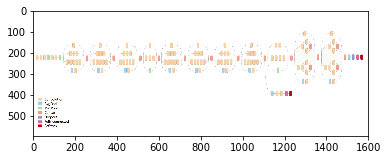

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf


image_raw_data =  tf.gfile.FastGFile("../../data/raw_image/image.png", "rb").read()

with tf.Session() as sess:
    img_data = tf.image.decode_png(image_raw_data)
    plt.imshow(img_data.eval())
    plt.show()

如下描述的是一个Inception模块，即最后一个全连接层前的Inception模块

### Inception-v3 module

In [ ]:
#Inception-v3模型共96个卷积层，用原始API会很冗长。TensorFlow-Slim可以简洁地实现卷积层
#通过TensorFlow-Slim可以在一行中实现一个卷积层的前向传播算法。slim.conv2d函数有三个参数是必填的：输入结点的矩阵、卷积核的深度和尺寸
#可选参数还有卷积核的步幅、padding、激活函数等
net=slim.conv2d(input, 32, [3, 3])

In [ ]:
#以下实现Inception相对复杂的模块，即最后一层并联Inception module
#slim.arg_scope函数可设置默认的参数取值。默认下stride=1, padding='SAME'。进一步减少冗余代码
#以下列表中的函数，将会使用后面定义的默认值
with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d], stride=1, padding='SAME')

#此处省略了Inception-v3模型中其它的网络结构而直接实现最后的并联Inception模块。
#若net为上一层的输出结点矩阵,以下首先为Inception模块声明一个统一的变量命名空间
with tf.variable_scope('Mixed_7c'):
    
    #为Inception模块中每一条路径声明一个命名空间
    with tf.variable_scope('Branch_0'):
        #实现一个卷积核尺寸为1，深度为320的卷积层
        branch_0=slim.conv2d(net, 320, [1, 1], scope='Conv2d_0a_1×1')
    
    #Inception模块中第二条路径，这条计算路径上的结构本身就是一个Inception模块
    with tf.variable_scope('Branch_1'):
        branch_1=slim.con2d(net, 384, [1, 1], scope='Conv2d_0a_1×1')
        
        #tf.concat函数可以将多个矩阵拼接起来，tf.concat第一个参数指定了拼接的维度，‘3’表示矩阵在深度这个维度上进行拼接
        branch_1=tf.concat(3, [slim.conv2d(branch_1, 384, [1, 3], scope='Conv2d_0b_1×3'),
                              slim.conv2d(branch_1, 384, [3, 1], scope='Conv2d_0c_3×1')])
        
    #Inception模块中第三条路径，该计算路径也是一个Inception结构
    with tf.variable_scope('Branch_2'):
        branch_2=slim.conv2d(net, 448, [1, 1], scope='Conv2d_0a_1×1')
        branch_2=slim.conv2d(branch_2, 384, [3, 3], scope='Conv2d_0b_3×3')
        branch_2=tf.concat(3, [slim.comv2d(branch_2, 384, [1, 3], scope='Conv2d_0c_1×3'), 
                              slim.conv2d(branch_2, 384, [3, 1], scope='Conv2d_0d_3×1')])
        
    #Inception 模块中第四条路径
    with tf.variable_scope('Branch_3'):
        branch_3=slim.avg_pool2d(net, [3, 3], scope='AcgPool_0a_3×3')
        branch_3=slim.conv2d(branch_3, 192, [1, 1], scope='Conv2d_0b_1×1')
        
    #当前Inception模块的最后输出是由上面四个计算结果拼接得到的
    net=tf.concat(3, [branch_0, branch_1, branch_2, branch_3])
    
